# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

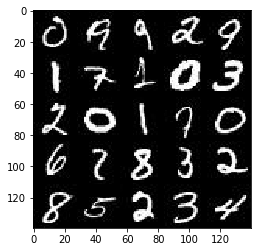

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

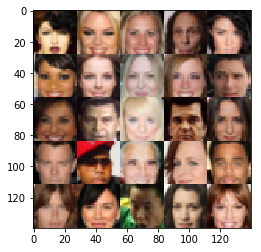

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name ='learning_rate')
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 7 * 7 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = False if is_train else True
    alpha = 0.2

    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    class GAN:
        def __init__(self, data_shape, z_size, learning_rate, alpha=0.2, beta1=0.5):
            #tf.reset_default_graph()
            _, image_width, image_height, image_channels = data_shape
            self.input_real, self.input_z, self.learning_rate = model_inputs(image_width, image_height, 
                                                                             image_channels, 
                                                                             z_size)

            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, image_channels)

            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, 0.5)

    net = GAN(data_shape, z_dim, learning_rate, alpha=0.2, beta1=beta1)

    saver = tf.train.Saver()

    samples, losses = [], []
    batches = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batches += 1
                batch_images = batch_images * 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z})

                if batches % 10 == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if batches % 100 == 0:
                    _ = show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)


    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.0404... Generator Loss: 0.1665
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.4023
Epoch 1/2... Discriminator Loss: 1.6990... Generator Loss: 0.2631
Epoch 1/2... Discriminator Loss: 2.2363... Generator Loss: 0.1654
Epoch 1/2... Discriminator Loss: 1.9725... Generator Loss: 0.2393
Epoch 1/2... Discriminator Loss: 1.7356... Generator Loss: 0.2169
Epoch 1/2... Discriminator Loss: 1.6235... Generator Loss: 0.2786
Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 0.3738
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 2.1882... Generator Loss: 0.1381


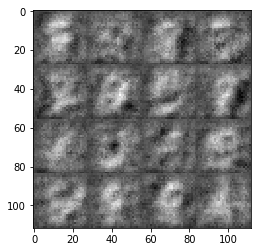

Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.5875
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 0.6249
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.5423
Epoch 1/2... Discriminator Loss: 2.0375... Generator Loss: 0.1615
Epoch 1/2... Discriminator Loss: 1.5504... Generator Loss: 0.3179
Epoch 1/2... Discriminator Loss: 1.4805... Generator Loss: 0.4590
Epoch 1/2... Discriminator Loss: 2.1546... Generator Loss: 0.1895
Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.9337
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 1.0579


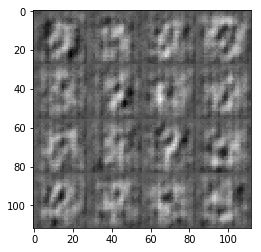

Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.4713... Generator Loss: 0.4180
Epoch 1/2... Discriminator Loss: 1.7355... Generator Loss: 0.2573
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 0.5211
Epoch 1/2... Discriminator Loss: 1.0841... Generator Loss: 0.8297
Epoch 1/2... Discriminator Loss: 1.2761... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 0.9520
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.5465
Epoch 1/2... Discriminator Loss: 1.6959... Generator Loss: 0.2653


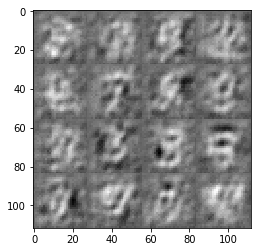

Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.3628
Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 0.5498
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 0.9426
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 0.5858
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 0.7594


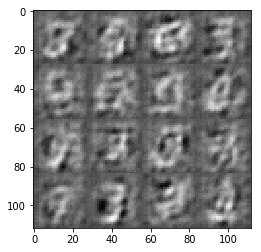

Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 0.6183
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 0.5751
Epoch 1/2... Discriminator Loss: 0.8938... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 0.7649... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.7020... Generator Loss: 0.2417
Epoch 1/2... Discriminator Loss: 0.5838... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.3539
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.6125
Epoch 1/2... Discriminator Loss: 0.7143... Generator Loss: 0.9675


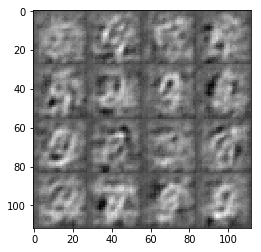

Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 0.5594
Epoch 1/2... Discriminator Loss: 0.7550... Generator Loss: 3.2369
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 0.5932
Epoch 1/2... Discriminator Loss: 0.6593... Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 1.3973
Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 0.7174
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 0.4613... Generator Loss: 1.4500
Epoch 1/2... Discriminator Loss: 1.8502... Generator Loss: 0.2699


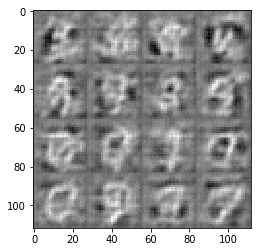

Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 0.6274
Epoch 1/2... Discriminator Loss: 2.1803... Generator Loss: 0.1482
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 1.1665
Epoch 1/2... Discriminator Loss: 0.8629... Generator Loss: 0.7784
Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 0.5690
Epoch 1/2... Discriminator Loss: 0.7507... Generator Loss: 0.8594
Epoch 1/2... Discriminator Loss: 0.8491... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 0.6332... Generator Loss: 1.0430


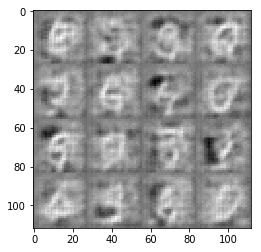

Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 0.9662
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.4498
Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 0.7575... Generator Loss: 1.0533
Epoch 1/2... Discriminator Loss: 0.6774... Generator Loss: 1.3082
Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 0.5105... Generator Loss: 1.4471
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 0.9057


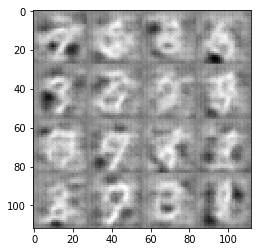

Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.3858
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.5716
Epoch 1/2... Discriminator Loss: 1.5635... Generator Loss: 0.3055
Epoch 1/2... Discriminator Loss: 1.1940... Generator Loss: 0.4827
Epoch 1/2... Discriminator Loss: 0.8079... Generator Loss: 1.9900
Epoch 1/2... Discriminator Loss: 1.1390... Generator Loss: 0.4977
Epoch 1/2... Discriminator Loss: 0.6411... Generator Loss: 1.1350
Epoch 1/2... Discriminator Loss: 1.8530... Generator Loss: 0.2207
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 0.7173


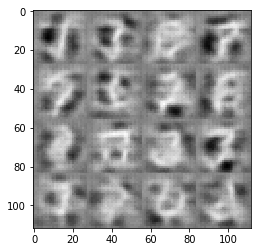

Epoch 1/2... Discriminator Loss: 1.7941... Generator Loss: 0.2554
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.5060
Epoch 1/2... Discriminator Loss: 1.2155... Generator Loss: 0.4911
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 0.3808
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 0.4258
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 2.1730
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 0.8034... Generator Loss: 1.7175
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.4087


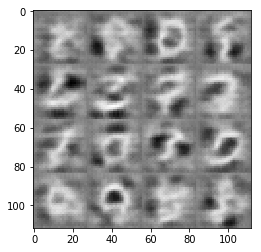

Epoch 1/2... Discriminator Loss: 0.5625... Generator Loss: 1.4302
Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.2687
Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 0.2824
Epoch 1/2... Discriminator Loss: 0.5845... Generator Loss: 1.5366
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.5592
Epoch 1/2... Discriminator Loss: 1.6699... Generator Loss: 0.2718
Epoch 1/2... Discriminator Loss: 0.6743... Generator Loss: 1.3207
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.3907
Epoch 1/2... Discriminator Loss: 0.6793... Generator Loss: 1.2411
Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 1.5732


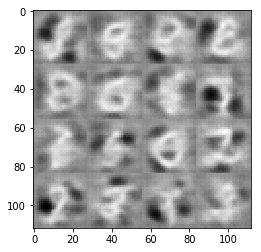

Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.5650
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 3.5830
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.5262
Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 0.4803
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 1.3003... Generator Loss: 0.3811
Epoch 1/2... Discriminator Loss: 0.6690... Generator Loss: 1.1448
Epoch 1/2... Discriminator Loss: 0.8434... Generator Loss: 0.9936


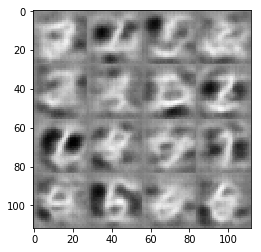

Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 0.6137
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.5268
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.5397
Epoch 1/2... Discriminator Loss: 1.4297... Generator Loss: 0.3476
Epoch 1/2... Discriminator Loss: 0.7846... Generator Loss: 1.6638
Epoch 1/2... Discriminator Loss: 0.7085... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 0.6854... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.3724


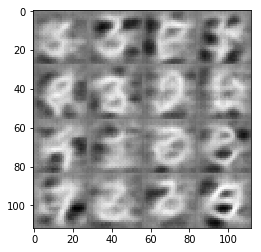

Epoch 1/2... Discriminator Loss: 0.6498... Generator Loss: 1.4027
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.5094
Epoch 1/2... Discriminator Loss: 0.5636... Generator Loss: 1.2034
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.4223
Epoch 1/2... Discriminator Loss: 0.8178... Generator Loss: 1.1619
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 0.5024
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 2.5026
Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 0.7349


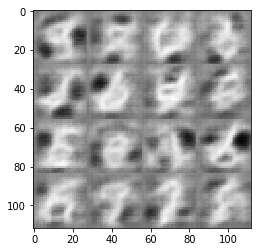

Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.3852
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 0.7652
Epoch 1/2... Discriminator Loss: 0.7042... Generator Loss: 0.9832
Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 0.4328
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 1.5877... Generator Loss: 0.3549
Epoch 1/2... Discriminator Loss: 1.2108... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 0.9683
Epoch 1/2... Discriminator Loss: 0.8801... Generator Loss: 0.7536


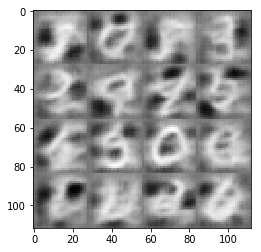

Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 1.0675
Epoch 1/2... Discriminator Loss: 0.5138... Generator Loss: 2.1458
Epoch 1/2... Discriminator Loss: 0.7675... Generator Loss: 1.2092
Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 0.6572
Epoch 1/2... Discriminator Loss: 0.7609... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 0.5797
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.5111
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 1.1360... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 0.6023


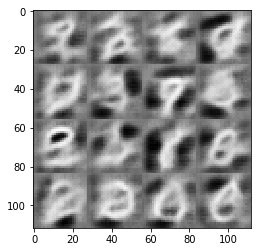

Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.4631
Epoch 1/2... Discriminator Loss: 0.5075... Generator Loss: 1.2416
Epoch 1/2... Discriminator Loss: 0.9673... Generator Loss: 0.6415
Epoch 1/2... Discriminator Loss: 0.6786... Generator Loss: 0.9514
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 0.6860
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 0.8498
Epoch 1/2... Discriminator Loss: 1.7714... Generator Loss: 0.2311
Epoch 1/2... Discriminator Loss: 0.7571... Generator Loss: 1.1656
Epoch 1/2... Discriminator Loss: 0.6386... Generator Loss: 1.1307


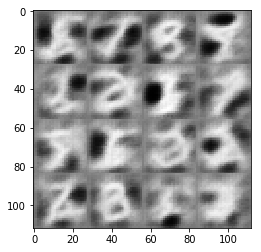

Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 0.9950
Epoch 1/2... Discriminator Loss: 0.9767... Generator Loss: 0.6276
Epoch 1/2... Discriminator Loss: 0.7591... Generator Loss: 0.7997
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 0.8980
Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 0.6383
Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 1.1086
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.6477
Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.8551... Generator Loss: 0.2344


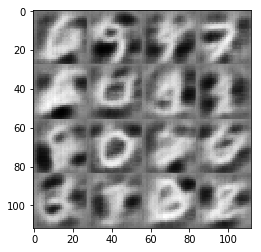

Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 1.7856... Generator Loss: 0.3654
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 1.6370
Epoch 1/2... Discriminator Loss: 0.7935... Generator Loss: 1.0105
Epoch 1/2... Discriminator Loss: 0.6953... Generator Loss: 1.5447
Epoch 1/2... Discriminator Loss: 0.6965... Generator Loss: 1.5423
Epoch 1/2... Discriminator Loss: 0.6237... Generator Loss: 1.1105
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 1.2764
Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 1.3005... Generator Loss: 0.5003


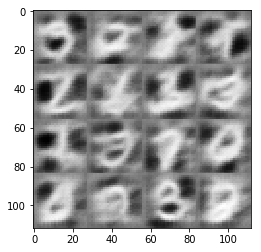

Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 0.7207
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.1332... Generator Loss: 0.6044
Epoch 2/2... Discriminator Loss: 0.4758... Generator Loss: 1.3079
Epoch 2/2... Discriminator Loss: 0.2709... Generator Loss: 2.0589
Epoch 2/2... Discriminator Loss: 0.7587... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 0.6795... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 0.7609
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 0.9158
Epoch 2/2... Discriminator Loss: 1.1744... Generator Loss: 0.6018


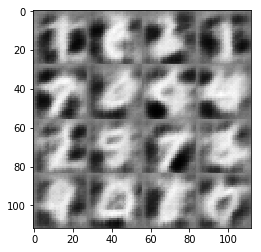

Epoch 2/2... Discriminator Loss: 0.9320... Generator Loss: 0.6715
Epoch 2/2... Discriminator Loss: 0.4654... Generator Loss: 1.3446
Epoch 2/2... Discriminator Loss: 0.8191... Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 0.7149... Generator Loss: 0.9569
Epoch 2/2... Discriminator Loss: 0.7014... Generator Loss: 0.8336
Epoch 2/2... Discriminator Loss: 0.7632... Generator Loss: 0.9128
Epoch 2/2... Discriminator Loss: 0.5896... Generator Loss: 1.0591
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 0.8657
Epoch 2/2... Discriminator Loss: 0.5528... Generator Loss: 1.2682
Epoch 2/2... Discriminator Loss: 1.3868... Generator Loss: 0.4209


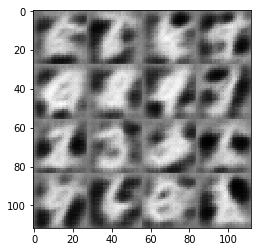

Epoch 2/2... Discriminator Loss: 0.4868... Generator Loss: 1.5029
Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.6147
Epoch 2/2... Discriminator Loss: 0.9600... Generator Loss: 0.6811
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 0.5693... Generator Loss: 2.0499
Epoch 2/2... Discriminator Loss: 0.6476... Generator Loss: 1.4285
Epoch 2/2... Discriminator Loss: 0.5309... Generator Loss: 1.9481
Epoch 2/2... Discriminator Loss: 0.5563... Generator Loss: 1.4178
Epoch 2/2... Discriminator Loss: 0.6609... Generator Loss: 1.6751
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 0.7777


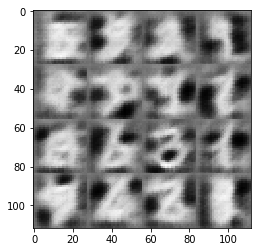

Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.4428
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.4771
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.5649
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 0.6194... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 1.0409... Generator Loss: 0.5024
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 0.7225... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 0.8090


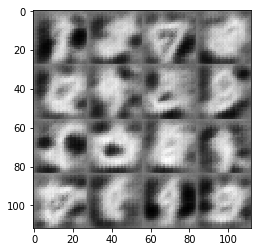

Epoch 2/2... Discriminator Loss: 0.8857... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 0.7528... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 0.7768... Generator Loss: 0.9017
Epoch 2/2... Discriminator Loss: 0.5642... Generator Loss: 1.1069
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 0.7544
Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 1.1351
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 0.9117
Epoch 2/2... Discriminator Loss: 0.5348... Generator Loss: 1.4984
Epoch 2/2... Discriminator Loss: 0.4732... Generator Loss: 1.3382


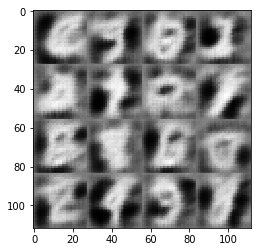

Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 0.4653
Epoch 2/2... Discriminator Loss: 0.9897... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.4920
Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 0.7614
Epoch 2/2... Discriminator Loss: 0.5517... Generator Loss: 1.1940
Epoch 2/2... Discriminator Loss: 0.7222... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.0381
Epoch 2/2... Discriminator Loss: 0.9802... Generator Loss: 0.8020
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.7852
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 0.7040


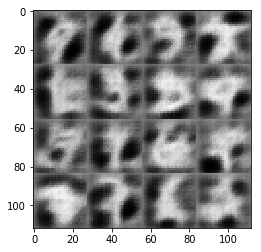

Epoch 2/2... Discriminator Loss: 0.6190... Generator Loss: 1.2106
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.4327
Epoch 2/2... Discriminator Loss: 0.4710... Generator Loss: 2.9219
Epoch 2/2... Discriminator Loss: 1.2024... Generator Loss: 0.8133
Epoch 2/2... Discriminator Loss: 0.9675... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 0.5374... Generator Loss: 1.1467
Epoch 2/2... Discriminator Loss: 0.6346... Generator Loss: 1.2095
Epoch 2/2... Discriminator Loss: 0.5416... Generator Loss: 1.1625
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 0.6359
Epoch 2/2... Discriminator Loss: 2.3191... Generator Loss: 4.7301


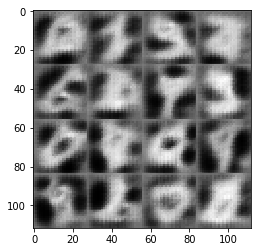

Epoch 2/2... Discriminator Loss: 0.8511... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 0.5614... Generator Loss: 1.3206
Epoch 2/2... Discriminator Loss: 0.5130... Generator Loss: 2.0405
Epoch 2/2... Discriminator Loss: 0.6841... Generator Loss: 1.5250
Epoch 2/2... Discriminator Loss: 0.5140... Generator Loss: 1.5259
Epoch 2/2... Discriminator Loss: 0.5578... Generator Loss: 2.1797
Epoch 2/2... Discriminator Loss: 0.6873... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 0.7116... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.5795
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.1843


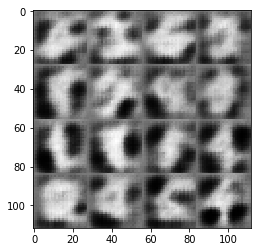

Epoch 2/2... Discriminator Loss: 1.9035... Generator Loss: 0.2659
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.0458
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 0.5229
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 0.6354
Epoch 2/2... Discriminator Loss: 1.4439... Generator Loss: 0.3547
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 0.9343
Epoch 2/2... Discriminator Loss: 0.9057... Generator Loss: 0.6833
Epoch 2/2... Discriminator Loss: 0.8817... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 0.8634... Generator Loss: 0.9359


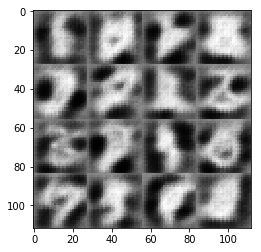

Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 0.9461
Epoch 2/2... Discriminator Loss: 0.5453... Generator Loss: 1.2534
Epoch 2/2... Discriminator Loss: 0.3675... Generator Loss: 1.4765
Epoch 2/2... Discriminator Loss: 1.1012... Generator Loss: 0.5538
Epoch 2/2... Discriminator Loss: 0.8967... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 0.7362... Generator Loss: 0.9296
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 0.6986... Generator Loss: 1.0561
Epoch 2/2... Discriminator Loss: 0.9617... Generator Loss: 0.6566
Epoch 2/2... Discriminator Loss: 0.4212... Generator Loss: 1.8629


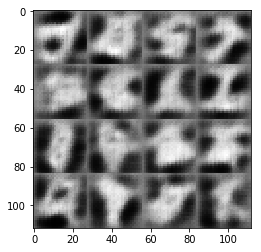

Epoch 2/2... Discriminator Loss: 3.3097... Generator Loss: 0.0577
Epoch 2/2... Discriminator Loss: 0.4885... Generator Loss: 2.2801
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 0.7636
Epoch 2/2... Discriminator Loss: 1.4411... Generator Loss: 0.4308
Epoch 2/2... Discriminator Loss: 0.7090... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 0.9556
Epoch 2/2... Discriminator Loss: 3.1678... Generator Loss: 0.0680
Epoch 2/2... Discriminator Loss: 0.4285... Generator Loss: 2.2625
Epoch 2/2... Discriminator Loss: 1.0072... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 1.6508... Generator Loss: 0.3042


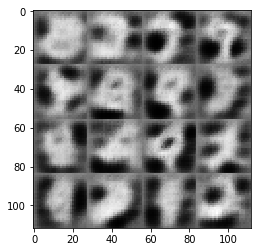

Epoch 2/2... Discriminator Loss: 0.8957... Generator Loss: 0.6734
Epoch 2/2... Discriminator Loss: 1.8056... Generator Loss: 0.2538
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.3898
Epoch 2/2... Discriminator Loss: 0.9177... Generator Loss: 0.7219
Epoch 2/2... Discriminator Loss: 0.5860... Generator Loss: 1.1765
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 0.6625... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 1.1708


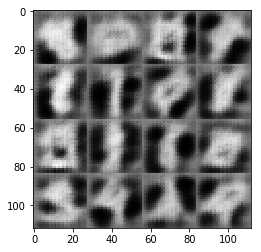

Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 0.7335
Epoch 2/2... Discriminator Loss: 0.5685... Generator Loss: 1.1024
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 0.6975
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 0.5959... Generator Loss: 0.9511
Epoch 2/2... Discriminator Loss: 0.5259... Generator Loss: 1.1839
Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 0.4852
Epoch 2/2... Discriminator Loss: 2.5418... Generator Loss: 0.3260
Epoch 2/2... Discriminator Loss: 0.8064... Generator Loss: 1.3719


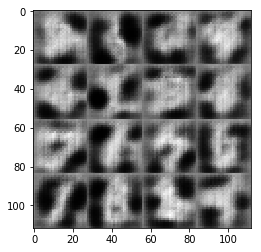

Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 1.2898
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 0.9655
Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 0.6765
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 0.5788
Epoch 2/2... Discriminator Loss: 1.0312... Generator Loss: 0.6763
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 0.4626... Generator Loss: 1.8181
Epoch 2/2... Discriminator Loss: 0.6635... Generator Loss: 1.1278
Epoch 2/2... Discriminator Loss: 1.2739... Generator Loss: 0.4349
Epoch 2/2... Discriminator Loss: 0.8429... Generator Loss: 0.7384


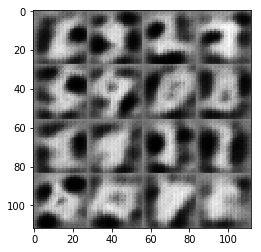

Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 0.7337... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 0.6575... Generator Loss: 1.0580
Epoch 2/2... Discriminator Loss: 1.2501... Generator Loss: 0.5657
Epoch 2/2... Discriminator Loss: 0.6024... Generator Loss: 1.3571
Epoch 2/2... Discriminator Loss: 0.3492... Generator Loss: 1.6908
Epoch 2/2... Discriminator Loss: 1.2094... Generator Loss: 0.5854
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.1839
Epoch 2/2... Discriminator Loss: 0.3778... Generator Loss: 1.6235


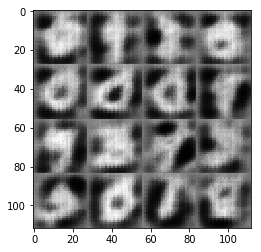

Epoch 2/2... Discriminator Loss: 0.4002... Generator Loss: 1.5138
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 0.6979
Epoch 2/2... Discriminator Loss: 3.3615... Generator Loss: 0.1500
Epoch 2/2... Discriminator Loss: 0.5516... Generator Loss: 1.3679
Epoch 2/2... Discriminator Loss: 0.5207... Generator Loss: 1.2875
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 1.5592
Epoch 2/2... Discriminator Loss: 0.9609... Generator Loss: 0.7255
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 0.4929... Generator Loss: 1.3239
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 0.6533


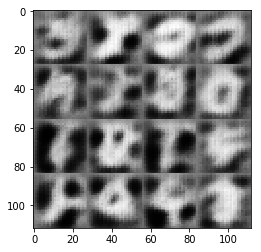

Epoch 2/2... Discriminator Loss: 0.6399... Generator Loss: 1.1040
Epoch 2/2... Discriminator Loss: 0.6291... Generator Loss: 1.2021
Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 0.7350
Epoch 2/2... Discriminator Loss: 0.3129... Generator Loss: 1.9377
Epoch 2/2... Discriminator Loss: 0.4731... Generator Loss: 1.2728
Epoch 2/2... Discriminator Loss: 0.6636... Generator Loss: 1.0233
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 0.5859
Epoch 2/2... Discriminator Loss: 1.1561... Generator Loss: 0.5875
Epoch 2/2... Discriminator Loss: 0.4503... Generator Loss: 1.6248


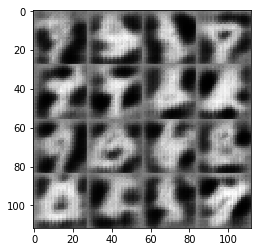

Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.6107
Epoch 2/2... Discriminator Loss: 1.1370... Generator Loss: 0.5994
Epoch 2/2... Discriminator Loss: 0.7643... Generator Loss: 1.6344
Epoch 2/2... Discriminator Loss: 0.4910... Generator Loss: 1.9253
Epoch 2/2... Discriminator Loss: 0.5032... Generator Loss: 1.7304
Epoch 2/2... Discriminator Loss: 1.2429... Generator Loss: 0.5281
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 0.5642
Epoch 2/2... Discriminator Loss: 0.4097... Generator Loss: 1.5961
Epoch 2/2... Discriminator Loss: 2.0964... Generator Loss: 0.1835


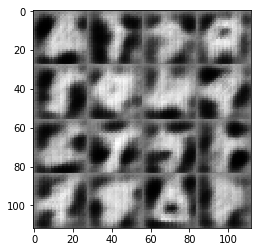

Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 0.6989... Generator Loss: 1.3031
Epoch 2/2... Discriminator Loss: 0.5831... Generator Loss: 1.2066
Epoch 2/2... Discriminator Loss: 0.8819... Generator Loss: 1.0055
Epoch 2/2... Discriminator Loss: 0.3395... Generator Loss: 2.1493


In [ ]:
batch_size = 32
z_dim = 500
learning_rate = 0.0001
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.3913... Generator Loss: 0.1272
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.4334
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 1.2861
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 0.2736... Generator Loss: 2.0248


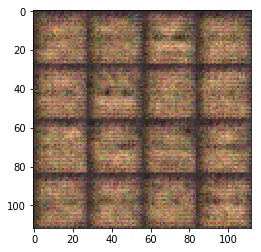

Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.1123
Epoch 1/1... Discriminator Loss: 0.2084... Generator Loss: 2.3684
Epoch 1/1... Discriminator Loss: 0.3966... Generator Loss: 1.6885
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 1.7333
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.1753
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 1.1624
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.9167... Generator Loss: 0.2344
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.4386


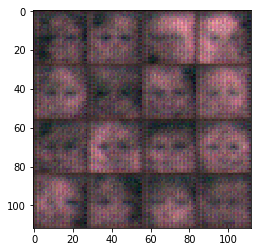

Epoch 1/1... Discriminator Loss: 1.9401... Generator Loss: 0.1687
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 1.5857
Epoch 1/1... Discriminator Loss: 0.4603... Generator Loss: 2.4982
Epoch 1/1... Discriminator Loss: 0.5161... Generator Loss: 3.2677
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.1865


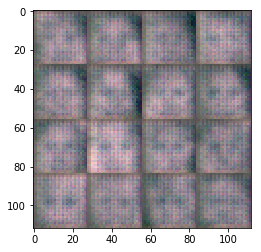

Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 1.3845
Epoch 1/1... Discriminator Loss: 0.3645... Generator Loss: 2.8621
Epoch 1/1... Discriminator Loss: 0.1507... Generator Loss: 3.5316
Epoch 1/1... Discriminator Loss: 0.1576... Generator Loss: 2.5834
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 1.6624
Epoch 1/1... Discriminator Loss: 0.2636... Generator Loss: 2.3903
Epoch 1/1... Discriminator Loss: 0.2675... Generator Loss: 1.8372
Epoch 1/1... Discriminator Loss: 0.2055... Generator Loss: 2.3054


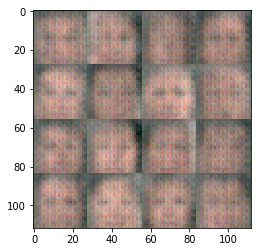

Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 0.5601... Generator Loss: 1.2075
Epoch 1/1... Discriminator Loss: 0.2046... Generator Loss: 1.9972
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.4683
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 1.3940
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 1.6103


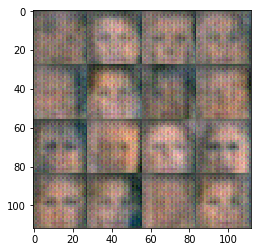

Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 1.4913
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.3515
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 3.7120
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 1.7468
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 2.2795
Epoch 1/1... Discriminator Loss: 0.1294... Generator Loss: 3.1216
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 1.9533
Epoch 1/1... Discriminator Loss: 1.8622... Generator Loss: 0.2603
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 1.5687
Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.1430


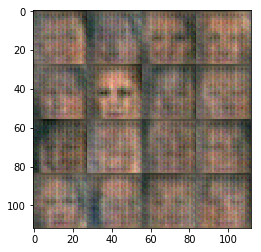

Epoch 1/1... Discriminator Loss: 0.3056... Generator Loss: 1.8642
Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 1.5326
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 0.7688... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 0.3519
Epoch 1/1... Discriminator Loss: 0.4217... Generator Loss: 1.7043
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 0.3775... Generator Loss: 2.0131
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.4819


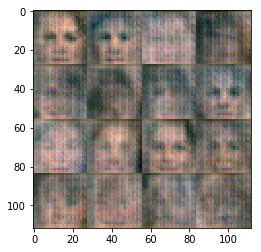

Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 2.0215... Generator Loss: 0.2310
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 0.2382... Generator Loss: 2.4544
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 1.7640
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 1.6245
Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 3.3041
Epoch 1/1... Discriminator Loss: 0.1457... Generator Loss: 3.0746
Epoch 1/1... Discriminator Loss: 0.0890... Generator Loss: 3.4854
Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 1.1142


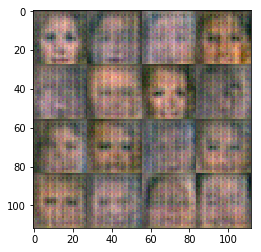

Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 2.9908
Epoch 1/1... Discriminator Loss: 0.4572... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 0.0872... Generator Loss: 4.6862
Epoch 1/1... Discriminator Loss: 0.1061... Generator Loss: 3.1396
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 0.1686... Generator Loss: 2.8394
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.0852


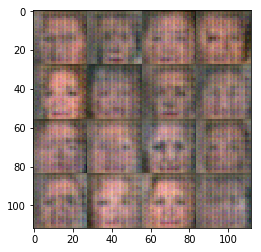

Epoch 1/1... Discriminator Loss: 1.6675... Generator Loss: 0.2891
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.3027
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5398
Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 0.0709... Generator Loss: 4.0608
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 3.7872
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 0.9695


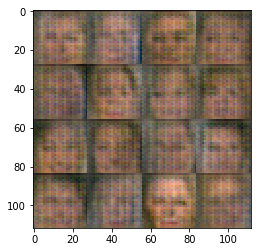

Epoch 1/1... Discriminator Loss: 0.2735... Generator Loss: 1.8876
Epoch 1/1... Discriminator Loss: 0.2200... Generator Loss: 2.2164
Epoch 1/1... Discriminator Loss: 0.2704... Generator Loss: 2.2105
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 0.0772... Generator Loss: 7.1270
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 0.5673... Generator Loss: 2.1830
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.4318


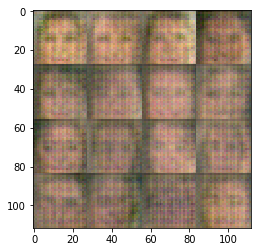

Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 2.0405... Generator Loss: 0.1923
Epoch 1/1... Discriminator Loss: 0.2152... Generator Loss: 2.4430
Epoch 1/1... Discriminator Loss: 0.1234... Generator Loss: 2.8298
Epoch 1/1... Discriminator Loss: 0.1204... Generator Loss: 2.5035
Epoch 1/1... Discriminator Loss: 0.2882... Generator Loss: 1.9881
Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 0.1578... Generator Loss: 2.8708
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.2165


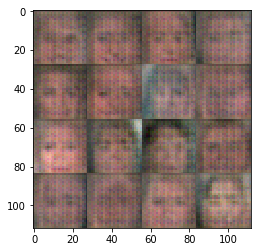

Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 0.3145... Generator Loss: 1.7961
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 1.5467
Epoch 1/1... Discriminator Loss: 3.8842... Generator Loss: 0.0465
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.4700
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 1.8017
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 0.2641... Generator Loss: 6.5919
Epoch 1/1... Discriminator Loss: 0.1981... Generator Loss: 2.5550
Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 4.9426


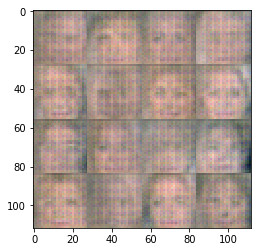

Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 5.3429
Epoch 1/1... Discriminator Loss: 0.0454... Generator Loss: 5.7293
Epoch 1/1... Discriminator Loss: 0.3384... Generator Loss: 1.9493
Epoch 1/1... Discriminator Loss: 0.1010... Generator Loss: 3.1565
Epoch 1/1... Discriminator Loss: 0.2580... Generator Loss: 2.5509
Epoch 1/1... Discriminator Loss: 0.0840... Generator Loss: 4.1114
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 1.7739
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 1.4607


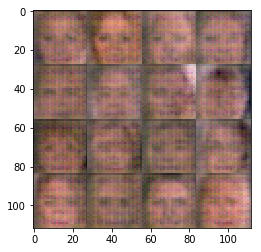

Epoch 1/1... Discriminator Loss: 0.2918... Generator Loss: 8.4050
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 3.4936
Epoch 1/1... Discriminator Loss: 0.0631... Generator Loss: 4.1048
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 6.6998
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.4297
Epoch 1/1... Discriminator Loss: 0.1145... Generator Loss: 3.8384
Epoch 1/1... Discriminator Loss: 0.0549... Generator Loss: 4.5499
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 6.7612
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 10.6617


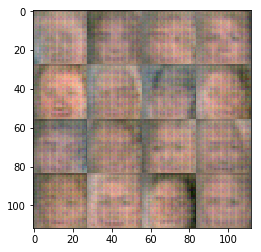

Epoch 1/1... Discriminator Loss: 0.2508... Generator Loss: 5.7298
Epoch 1/1... Discriminator Loss: 0.0486... Generator Loss: 6.0633
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 0.6038... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 0.1728... Generator Loss: 8.2881
Epoch 1/1... Discriminator Loss: 0.1447... Generator Loss: 2.9309
Epoch 1/1... Discriminator Loss: 0.0800... Generator Loss: 3.7342
Epoch 1/1... Discriminator Loss: 0.0611... Generator Loss: 3.5099
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 6.6384
Epoch 1/1... Discriminator Loss: 0.0204... Generator Loss: 8.7012


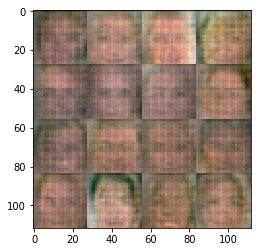

Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 0.0404... Generator Loss: 6.0494
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 4.0377
Epoch 1/1... Discriminator Loss: 0.2155... Generator Loss: 6.5515
Epoch 1/1... Discriminator Loss: 0.0424... Generator Loss: 8.3959
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 0.0267... Generator Loss: 11.4069
Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 6.9245
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 0.0543... Generator Loss: 8.2683


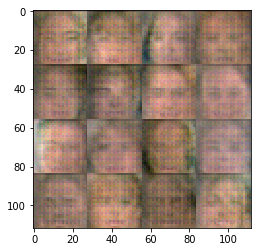

Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.2796
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 0.0483... Generator Loss: 12.4490
Epoch 1/1... Discriminator Loss: 0.0276... Generator Loss: 6.9466
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 2.0269
Epoch 1/1... Discriminator Loss: 0.1215... Generator Loss: 5.0334
Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 7.4920
Epoch 1/1... Discriminator Loss: 0.0416... Generator Loss: 13.0858
Epoch 1/1... Discriminator Loss: 0.0443... Generator Loss: 5.0063
Epoch 1/1... Discriminator Loss: 0.0356... Generator Loss: 4.0330


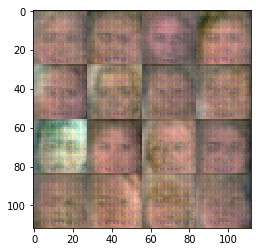

Epoch 1/1... Discriminator Loss: 3.3544... Generator Loss: 0.0620
Epoch 1/1... Discriminator Loss: 0.2247... Generator Loss: 8.2540
Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 1.8166
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 10.5647
Epoch 1/1... Discriminator Loss: 0.0327... Generator Loss: 9.8551
Epoch 1/1... Discriminator Loss: 0.0383... Generator Loss: 8.3875
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 6.8196
Epoch 1/1... Discriminator Loss: 0.1810... Generator Loss: 4.8383
Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 3.4828
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 3.0965


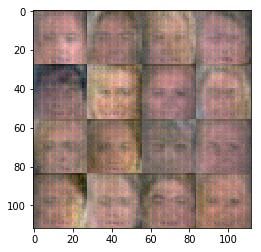

Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 0.2190... Generator Loss: 3.8642
Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 3.2130
Epoch 1/1... Discriminator Loss: 0.0968... Generator Loss: 6.6127
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 0.1540... Generator Loss: 2.4673
Epoch 1/1... Discriminator Loss: 0.0207... Generator Loss: 7.3904
Epoch 1/1... Discriminator Loss: 3.0104... Generator Loss: 0.0736
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 11.9612
Epoch 1/1... Discriminator Loss: 0.1635... Generator Loss: 2.6506


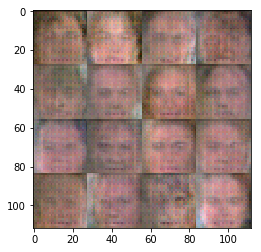

Epoch 1/1... Discriminator Loss: 0.0405... Generator Loss: 4.6415
Epoch 1/1... Discriminator Loss: 2.3211... Generator Loss: 0.1599
Epoch 1/1... Discriminator Loss: 0.0481... Generator Loss: 8.4102
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 11.1668
Epoch 1/1... Discriminator Loss: 0.9137... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 0.0608... Generator Loss: 5.8494
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 0.0700... Generator Loss: 3.5310
Epoch 1/1... Discriminator Loss: 0.0260... Generator Loss: 14.1138
Epoch 1/1... Discriminator Loss: 0.2822... Generator Loss: 1.7189


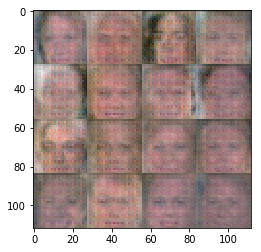

Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 2.7367
Epoch 1/1... Discriminator Loss: 0.0392... Generator Loss: 4.1648
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 7.6430
Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 3.5469
Epoch 1/1... Discriminator Loss: 0.1375... Generator Loss: 2.4497
Epoch 1/1... Discriminator Loss: 0.0178... Generator Loss: 4.8723
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 6.6665
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 5.3443


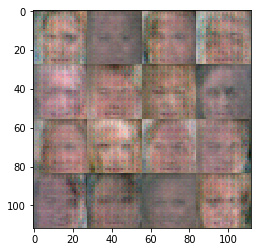

Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 0.0913... Generator Loss: 4.8578
Epoch 1/1... Discriminator Loss: 0.0466... Generator Loss: 5.3437
Epoch 1/1... Discriminator Loss: 0.1380... Generator Loss: 2.4717
Epoch 1/1... Discriminator Loss: 0.4083... Generator Loss: 1.6071
Epoch 1/1... Discriminator Loss: 0.0766... Generator Loss: 4.6099
Epoch 1/1... Discriminator Loss: 0.1367... Generator Loss: 5.3825
Epoch 1/1... Discriminator Loss: 0.1038... Generator Loss: 3.5017
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 3.7543
Epoch 1/1... Discriminator Loss: 0.0537... Generator Loss: 7.0527


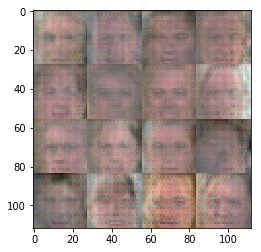

Epoch 1/1... Discriminator Loss: 0.1317... Generator Loss: 2.9081
Epoch 1/1... Discriminator Loss: 0.1100... Generator Loss: 3.1123
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 6.1180
Epoch 1/1... Discriminator Loss: 0.0090... Generator Loss: 7.2347
Epoch 1/1... Discriminator Loss: 0.0274... Generator Loss: 7.4509
Epoch 1/1... Discriminator Loss: 0.0544... Generator Loss: 4.0481
Epoch 1/1... Discriminator Loss: 0.0643... Generator Loss: 7.7291
Epoch 1/1... Discriminator Loss: 0.0219... Generator Loss: 8.7765
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 1.4379
Epoch 1/1... Discriminator Loss: 0.1438... Generator Loss: 2.7670


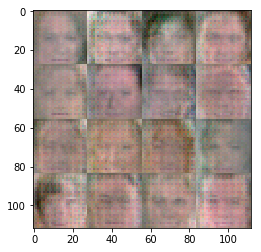

Epoch 1/1... Discriminator Loss: 0.0549... Generator Loss: 5.6668
Epoch 1/1... Discriminator Loss: 0.0091... Generator Loss: 5.7357
Epoch 1/1... Discriminator Loss: 0.0908... Generator Loss: 3.6846
Epoch 1/1... Discriminator Loss: 0.0594... Generator Loss: 3.7695
Epoch 1/1... Discriminator Loss: 0.0178... Generator Loss: 8.9729
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 0.0357... Generator Loss: 5.2480
Epoch 1/1... Discriminator Loss: 0.0143... Generator Loss: 6.5918
Epoch 1/1... Discriminator Loss: 0.0409... Generator Loss: 8.1754
Epoch 1/1... Discriminator Loss: 0.0615... Generator Loss: 3.4029


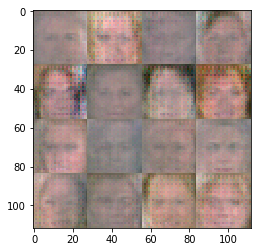

Epoch 1/1... Discriminator Loss: 0.0391... Generator Loss: 6.1734
Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 8.7216
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 3.2263
Epoch 1/1... Discriminator Loss: 0.0250... Generator Loss: 7.3109
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 6.6244
Epoch 1/1... Discriminator Loss: 0.0557... Generator Loss: 4.3429
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 5.0110
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 3.2349
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 0.0451... Generator Loss: 6.0738


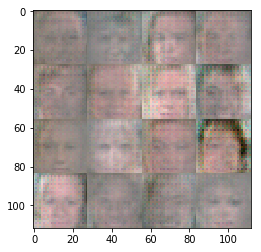

Epoch 1/1... Discriminator Loss: 0.0583... Generator Loss: 4.7588
Epoch 1/1... Discriminator Loss: 0.1296... Generator Loss: 5.8893
Epoch 1/1... Discriminator Loss: 0.2522... Generator Loss: 3.3739
Epoch 1/1... Discriminator Loss: 0.1091... Generator Loss: 2.6469
Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 5.3618
Epoch 1/1... Discriminator Loss: 0.1278... Generator Loss: 2.4936
Epoch 1/1... Discriminator Loss: 0.0404... Generator Loss: 4.4118
Epoch 1/1... Discriminator Loss: 0.0520... Generator Loss: 4.5611
Epoch 1/1... Discriminator Loss: 0.0608... Generator Loss: 7.8048
Epoch 1/1... Discriminator Loss: 0.0181... Generator Loss: 6.5775


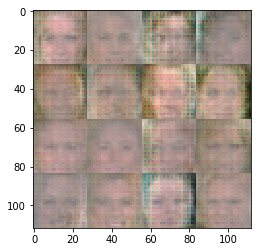

Epoch 1/1... Discriminator Loss: 0.0649... Generator Loss: 7.2925
Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 5.3027
Epoch 1/1... Discriminator Loss: 0.0690... Generator Loss: 3.5038
Epoch 1/1... Discriminator Loss: 0.0762... Generator Loss: 5.7402
Epoch 1/1... Discriminator Loss: 0.0420... Generator Loss: 6.6548
Epoch 1/1... Discriminator Loss: 0.0176... Generator Loss: 6.5912
Epoch 1/1... Discriminator Loss: 0.0512... Generator Loss: 4.9381
Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 7.3654
Epoch 1/1... Discriminator Loss: 0.0875... Generator Loss: 5.5941
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 6.6552


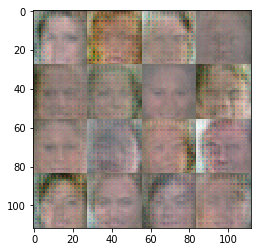

Epoch 1/1... Discriminator Loss: 0.0903... Generator Loss: 7.4337
Epoch 1/1... Discriminator Loss: 0.0163... Generator Loss: 5.1589
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 3.3529
Epoch 1/1... Discriminator Loss: 0.0377... Generator Loss: 5.2632
Epoch 1/1... Discriminator Loss: 0.0514... Generator Loss: 6.1199
Epoch 1/1... Discriminator Loss: 0.1345... Generator Loss: 3.5881
Epoch 1/1... Discriminator Loss: 0.0289... Generator Loss: 5.2708
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 3.9773
Epoch 1/1... Discriminator Loss: 0.0306... Generator Loss: 6.0148
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 5.3694


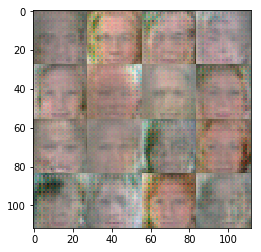

Epoch 1/1... Discriminator Loss: 0.2315... Generator Loss: 1.8601
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 4.8827
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 0.5365... Generator Loss: 3.5480
Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 2.5979
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 4.3732
Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 7.4156
Epoch 1/1... Discriminator Loss: 0.1335... Generator Loss: 3.1546
Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 8.9327


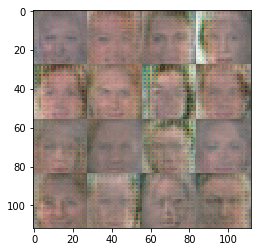

Epoch 1/1... Discriminator Loss: 0.0317... Generator Loss: 5.2959
Epoch 1/1... Discriminator Loss: 0.0446... Generator Loss: 3.7668
Epoch 1/1... Discriminator Loss: 0.2201... Generator Loss: 1.8457
Epoch 1/1... Discriminator Loss: 0.0847... Generator Loss: 3.3536
Epoch 1/1... Discriminator Loss: 0.0377... Generator Loss: 4.1839
Epoch 1/1... Discriminator Loss: 0.0171... Generator Loss: 5.4270
Epoch 1/1... Discriminator Loss: 0.0991... Generator Loss: 3.0552
Epoch 1/1... Discriminator Loss: 0.1476... Generator Loss: 2.5734
Epoch 1/1... Discriminator Loss: 0.1627... Generator Loss: 6.4427
Epoch 1/1... Discriminator Loss: 0.1404... Generator Loss: 5.4092


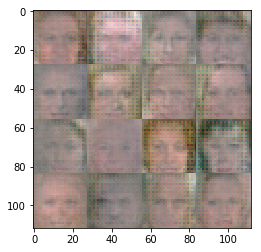

Epoch 1/1... Discriminator Loss: 0.0153... Generator Loss: 7.0255
Epoch 1/1... Discriminator Loss: 0.1583... Generator Loss: 2.5128
Epoch 1/1... Discriminator Loss: 0.0639... Generator Loss: 3.4659
Epoch 1/1... Discriminator Loss: 0.0703... Generator Loss: 6.0723
Epoch 1/1... Discriminator Loss: 0.0377... Generator Loss: 6.1588
Epoch 1/1... Discriminator Loss: 0.0373... Generator Loss: 6.8204
Epoch 1/1... Discriminator Loss: 0.0508... Generator Loss: 4.7601
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 4.5496
Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 6.4820
Epoch 1/1... Discriminator Loss: 0.0269... Generator Loss: 6.4504


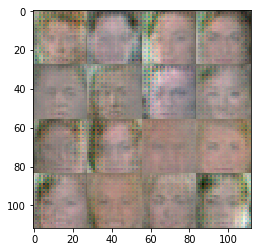

Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 5.9493
Epoch 1/1... Discriminator Loss: 0.0263... Generator Loss: 8.4132
Epoch 1/1... Discriminator Loss: 0.1318... Generator Loss: 7.5505
Epoch 1/1... Discriminator Loss: 0.0211... Generator Loss: 6.6882
Epoch 1/1... Discriminator Loss: 0.0406... Generator Loss: 5.3498
Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 5.4877
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 6.9182
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.3580
Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.4037... Generator Loss: 2.1131


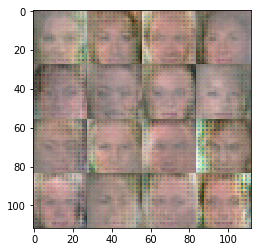

Epoch 1/1... Discriminator Loss: 0.1001... Generator Loss: 3.1763
Epoch 1/1... Discriminator Loss: 0.0548... Generator Loss: 6.1406
Epoch 1/1... Discriminator Loss: 0.0703... Generator Loss: 7.7255
Epoch 1/1... Discriminator Loss: 0.0304... Generator Loss: 8.5456
Epoch 1/1... Discriminator Loss: 0.0458... Generator Loss: 4.6656
Epoch 1/1... Discriminator Loss: 0.0453... Generator Loss: 3.7435
Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 4.1758
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 4.2999
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 0.0466... Generator Loss: 3.8610


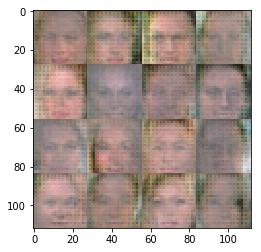

Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 5.3415
Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 4.7565
Epoch 1/1... Discriminator Loss: 0.1965... Generator Loss: 5.1509
Epoch 1/1... Discriminator Loss: 0.0651... Generator Loss: 6.2153
Epoch 1/1... Discriminator Loss: 0.0437... Generator Loss: 4.7847
Epoch 1/1... Discriminator Loss: 0.2996... Generator Loss: 1.7930
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 4.2235
Epoch 1/1... Discriminator Loss: 0.0238... Generator Loss: 4.3374
Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 1.2230
Epoch 1/1... Discriminator Loss: 0.2299... Generator Loss: 1.9519


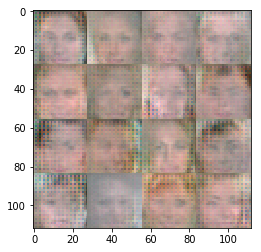

Epoch 1/1... Discriminator Loss: 0.0347... Generator Loss: 5.2831
Epoch 1/1... Discriminator Loss: 0.1164... Generator Loss: 2.6958
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 4.8843
Epoch 1/1... Discriminator Loss: 0.0273... Generator Loss: 6.2122
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 5.2345
Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 4.1746
Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 4.4090
Epoch 1/1... Discriminator Loss: 0.0357... Generator Loss: 6.7515
Epoch 1/1... Discriminator Loss: 0.2386... Generator Loss: 1.8928
Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 0.8880


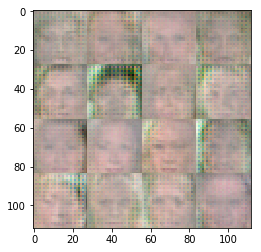

Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.3067
Epoch 1/1... Discriminator Loss: 0.0614... Generator Loss: 3.2091
Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 7.3365
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 7.6961
Epoch 1/1... Discriminator Loss: 0.0704... Generator Loss: 4.0072
Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 6.7368
Epoch 1/1... Discriminator Loss: 0.0351... Generator Loss: 4.7268
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 6.6324
Epoch 1/1... Discriminator Loss: 0.2739... Generator Loss: 1.7536


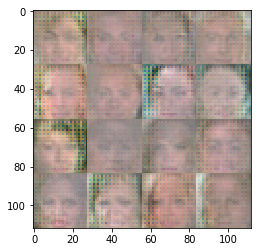

Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 4.2785
Epoch 1/1... Discriminator Loss: 0.0481... Generator Loss: 3.9530
Epoch 1/1... Discriminator Loss: 0.0471... Generator Loss: 4.7907
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 3.7999
Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 2.8472
Epoch 1/1... Discriminator Loss: 0.0673... Generator Loss: 3.9945
Epoch 1/1... Discriminator Loss: 0.0400... Generator Loss: 4.1678
Epoch 1/1... Discriminator Loss: 0.0882... Generator Loss: 4.1976
Epoch 1/1... Discriminator Loss: 0.0363... Generator Loss: 4.7105
Epoch 1/1... Discriminator Loss: 0.0387... Generator Loss: 4.5242


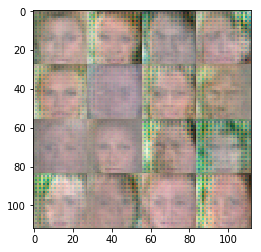

Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 4.3010
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 1.9855
Epoch 1/1... Discriminator Loss: 2.3612... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 0.5527... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 1.2763
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 1.5922
Epoch 1/1... Discriminator Loss: 0.2964... Generator Loss: 2.1887
Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 1.5179


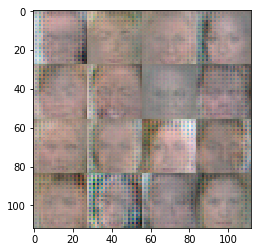

Epoch 1/1... Discriminator Loss: 0.0963... Generator Loss: 3.0250
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 0.0576... Generator Loss: 4.0484
Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 0.1110... Generator Loss: 2.9813
Epoch 1/1... Discriminator Loss: 0.1070... Generator Loss: 3.3056
Epoch 1/1... Discriminator Loss: 0.0660... Generator Loss: 4.1229
Epoch 1/1... Discriminator Loss: 0.2331... Generator Loss: 2.1190
Epoch 1/1... Discriminator Loss: 0.1206... Generator Loss: 2.9260
Epoch 1/1... Discriminator Loss: 0.0895... Generator Loss: 3.4674


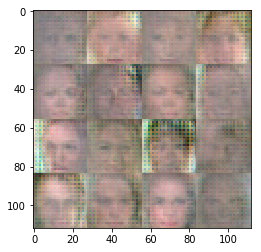

Epoch 1/1... Discriminator Loss: 0.0763... Generator Loss: 3.6546
Epoch 1/1... Discriminator Loss: 0.1913... Generator Loss: 2.6372
Epoch 1/1... Discriminator Loss: 0.3300... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 0.2419... Generator Loss: 1.7086
Epoch 1/1... Discriminator Loss: 0.0585... Generator Loss: 4.1604
Epoch 1/1... Discriminator Loss: 0.0527... Generator Loss: 6.0768
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 4.3908
Epoch 1/1... Discriminator Loss: 0.0387... Generator Loss: 3.9512
Epoch 1/1... Discriminator Loss: 0.0443... Generator Loss: 4.7970
Epoch 1/1... Discriminator Loss: 0.0683... Generator Loss: 3.4805


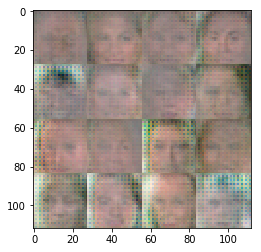

Epoch 1/1... Discriminator Loss: 0.1535... Generator Loss: 2.3683
Epoch 1/1... Discriminator Loss: 0.1794... Generator Loss: 2.1504
Epoch 1/1... Discriminator Loss: 0.0600... Generator Loss: 4.3009
Epoch 1/1... Discriminator Loss: 0.0608... Generator Loss: 5.9253
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 3.1997
Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 3.9441
Epoch 1/1... Discriminator Loss: 0.0469... Generator Loss: 5.2884
Epoch 1/1... Discriminator Loss: 0.0773... Generator Loss: 4.1882
Epoch 1/1... Discriminator Loss: 0.0761... Generator Loss: 3.1883
Epoch 1/1... Discriminator Loss: 0.1477... Generator Loss: 2.4905


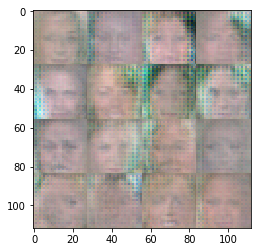

Epoch 1/1... Discriminator Loss: 0.0837... Generator Loss: 3.4523
Epoch 1/1... Discriminator Loss: 0.1120... Generator Loss: 3.4971
Epoch 1/1... Discriminator Loss: 0.0918... Generator Loss: 3.1370
Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 1.6631
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 4.4187
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.6721
Epoch 1/1... Discriminator Loss: 0.3848... Generator Loss: 1.6398
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 0.2105... Generator Loss: 2.3970


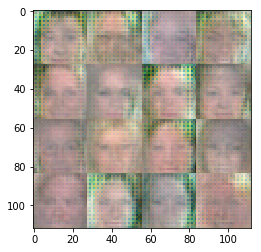

Epoch 1/1... Discriminator Loss: 0.1550... Generator Loss: 2.7280
Epoch 1/1... Discriminator Loss: 0.1597... Generator Loss: 2.5449
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 2.4417
Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 4.4543
Epoch 1/1... Discriminator Loss: 0.1341... Generator Loss: 2.4130
Epoch 1/1... Discriminator Loss: 0.2372... Generator Loss: 2.0792
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 0.2339... Generator Loss: 4.4393
Epoch 1/1... Discriminator Loss: 0.0639... Generator Loss: 3.2824
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.5618


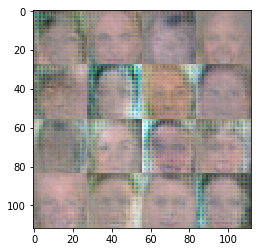

Epoch 1/1... Discriminator Loss: 0.1522... Generator Loss: 2.5948
Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 5.7299
Epoch 1/1... Discriminator Loss: 0.0676... Generator Loss: 4.6085
Epoch 1/1... Discriminator Loss: 0.0516... Generator Loss: 3.6942
Epoch 1/1... Discriminator Loss: 0.3244... Generator Loss: 1.5568
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 0.9637
Epoch 1/1... Discriminator Loss: 0.0551... Generator Loss: 4.6280
Epoch 1/1... Discriminator Loss: 0.0494... Generator Loss: 5.8207
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 0.0374... Generator Loss: 4.0025


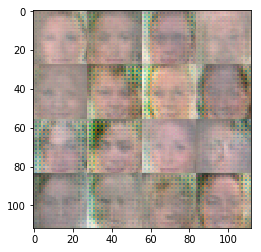

Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 3.9689
Epoch 1/1... Discriminator Loss: 0.1041... Generator Loss: 2.8591
Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 3.6357
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 5.9712
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 5.9826
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 1.5024
Epoch 1/1... Discriminator Loss: 0.1120... Generator Loss: 3.1125
Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 6.9310
Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 5.5095


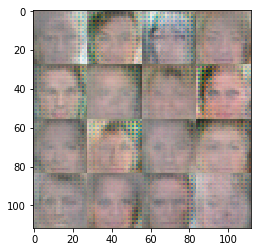

Epoch 1/1... Discriminator Loss: 0.1747... Generator Loss: 2.0788
Epoch 1/1... Discriminator Loss: 0.0221... Generator Loss: 6.0455
Epoch 1/1... Discriminator Loss: 0.2199... Generator Loss: 1.9359
Epoch 1/1... Discriminator Loss: 0.0186... Generator Loss: 5.1908
Epoch 1/1... Discriminator Loss: 0.0406... Generator Loss: 4.8455
Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 1.7222
Epoch 1/1... Discriminator Loss: 1.9795... Generator Loss: 5.7528


In [ ]:
batch_size = 32
z_dim = 500
learning_rate = 0.0001
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.